In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Exploratory Data Analysis

First few rows:
       id occurred_date_time            city state     shape    duration  \
0  147518      7/12/19 09:20         Redding    CA  Cylinder   5 minutes   
1  147514      7/12/19 03:30       Charlotte    NC     Other  20 minutes   
2  147511      7/11/19 22:40     Cedar Creek    TX     Other  20 seconds   
3  147512      7/11/19 22:10  San Bernardino    CA  Triangle   2 minutes   
4  147509      7/11/19 22:00   Bowling Green    KY     Other  45 minutes   

                                             summary  \
0  North Redding, CA.  We saw a bright flashing w...   
1  Whooshing sound with 1-red and 3-white lights ...   
2  Sitting on my front porch a few minutes ago, w...   
3  On the freeway on my way home from a distance....   
4  Me and my girlfriend watched as we first seen ...   

                                         details_url posted_date  
0  http://www.nuforc.org/webreports/147/S147518.html     7/12/19  
1  http://www.nuforc.org/webreports/147/S147514.html    

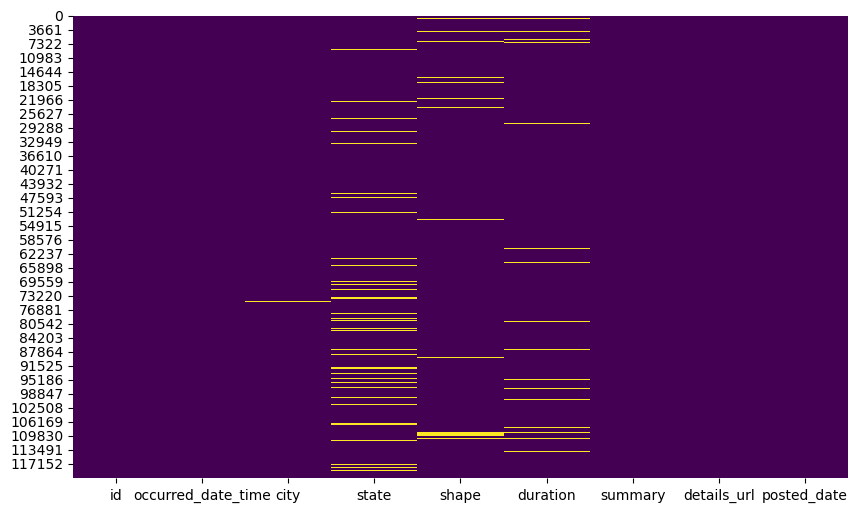

In [3]:
file_path = "ufo_data.csv"
df = pd.read_csv(file_path)

# get some basic information about the dataset
print("First few rows:")
print(df.head())
print("\n")

print("General info:")
print(df.info())
print("\n")

print("Summary statistics:")
print(df.describe())
print("\n")

# get more information about missing values
print("Missing values: ")
print(df.isnull().sum())

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.savefig('plots/missingValues.png')
plt.show()

While there aren't ***too many*** NaN values in the dataset, the columns which have the most NaNs are important.

The "state" column has the most, and I don't want to fill in any missing values for the sake of accuracy. For example, I don't want to fill a row whose "city" column has "Kentucky" with the state of "CA" as that's simply incorrect. 

Values in the "duration" column being stored as strings and as inconsistent measures (seconds, minutes, etc.) is also problematic as I won't be able to fill missing values as easily without standardizing first.

The "shape" column could realstically be filled, though I don't feel it's necessary to fill for the sake of only one column.

With this, I will drop all rows that contain NaN values, standardize the "duration" column to seconds, standardize the "occured_date_time" to only the date, and drop all rows with non-US locations. 

### Clean and Standardize the Data

In [6]:
file_path = "ufo_data.csv"
df = pd.read_csv(file_path)

# drop initial NaNs
df_dropped_nas = df.dropna(subset=["shape", "duration", "occurred_date_time", "state", "city"])

# Cleaning function takes in dataframe, column, and patterns to filter out worthless and/or inconsistent values
# Function also standardizes the date and filters out the time in "occurred_date_time" column
def clean_dataframe(df, column_name, patterns):
    # remove rows containing specified patterns in the "occured_date_time" column
    for pattern in patterns:
        df = df[~df[column_name].str.contains(pattern, regex=True, na=False)]

    # convert "occured_date_time" to datetime and keep only valid dates
    df[column_name] = pd.to_datetime(df[column_name], errors="coerce", format="%m/%d/%y %H:%M")

    df = df.dropna(subset=[column_name])

    # format column to keep only the date
    df[column_name] = df[column_name].dt.strftime('%m/%d/%y')
    
    return df

# set the column to clean and pattern to filter
column_name = "occurred_date_time"
patterns = [r'\?', r'unknown', r'&', r'ongoing']

df_cleaned_dates = clean_dataframe(df_dropped_nas, column_name, patterns)

# Cleaning function to standardize time measurement in "duration" column to seconds
def clean_duration(df, column_name, filter_values):
    # join filter values into one regex
    pattern = "|".join(filter_values)

    # remove rows containing filter values in "duration"
    df_cleaned = df[~df[column_name].str.contains(pattern, case=False, na=False)]

    # function to convert duration to seconds
    def convert_to_seconds(duration):
    
        duration = duration.lower()

        match = re.match(r'(\d+)\s*(seconds|minutes|hours?)', duration)

        if match:
            value = int(match.group(1))
            unit = match.group(2)

            if 'second' in unit:
                return value
            elif 'minute' in unit:
                return value * 60
            elif 'hour' in unit:
                return value * 3600
        return None

    # apply conversion function and drop NaNs
    df_cleaned.loc[:, column_name] = df_cleaned[column_name].apply(convert_to_seconds)
    df_cleaned = df_cleaned.dropna(subset=[column_name])
    return df_cleaned

# values to filter from "duration" column
filter_values = ["months", "years", "constant", "few", "ongoing"]
df_cleaned_duration = clean_duration(df_cleaned_dates, "duration", filter_values)

# Cleaning function to filter out non-US locations from "city" column
def clean_city(df, column_name, filter_values):
    # join values into one regex
    pattern = "|".join(filter_values)

    # remove rows containing filter values
    df = df[~df[column_name].str.contains(pattern, case=False, regex=True, na=False)]

    # drop rows with NaNs in "city" column
    df = df.dropna(subset=[column_name])

    return df

# big ol' list of non-US countries to filter out
city_filters = ["(Canada)", "(Portugal)", "(Spain)", "(Germany)", "(UK)", "(England)", "(Brazil)", "(Ecuador)", 
                "(Estonia)", "(Puerto Rico)", "(South Africa)", "(France)", "(Philippines)", "(Nigeria)", 
                "(Holland)", "(Australia)", "(Ireland)", "(Colombia)", "(Scotland)", "(Cyprus)", "(South Korea)",
                "(Norway)", "(Croatia)", "(Italy)", "(Singapore)", "(Chile)", "(Malta)", "(Greece)", "(Syria)", 
                "(Sweden)", "(Kyrgyzstan)", "(Myanmar)", "(Japan)", "(Mexico)", "(Argentina)", "(Egypt)", "(Poland)",
                "(Turkey)", "(Iraq)", "(India)", "(Jamaica)", "(Malaysia)", "(Venezuela)", "(Israel)", "(Kosovo)", 
                "(Belize)", "(Belgium)", "(Jordan)", "(Costa Rica)", "(Netherlands)", "(The Netherlands)", "(New Zealand)",
                "(Corsica)", "(in former Yugoslavia)", "(Bahamas)", "(location unspecified)", "(Serbia)", "(Iran)", "(Pakistan)", 
                "(Finland)", "(Botswana)", "(Dominican Republic)", r"\?", "(Saudi Arabia)", "(Indonesia)", "(Denmark)", "(Cambodia)",
                "(Russia)", "(China)"] 

df_cleaned_city = clean_city(df_cleaned_duration, "city", city_filters)

# one last NaN drop
df_cleaned_city.dropna()

# standardize capitalization in "shape" and "state" columns
df_cleaned_city['shape'] = df_cleaned_city['shape'].str.lower()
df_cleaned_city['state'] = df_cleaned_city['state'].str.upper()

output_path = "cleaned_data.csv"
df_cleaned_city.to_csv(output_path, index=False)

C:\Users\kylea\AppData\Local\Temp\ipykernel_8900\310214415.py:72: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[~df[column_name].str.contains(pattern, case=False, regex=True, na=False)]


### Calculate Basic Statistics

In [7]:
# import cleaned dataset
cleaned_file_path = "cleaned_data.csv"
df = pd.read_csv(cleaned_file_path)

# general numeric statistics
numeric_stats = df.describe()
print(f"numerical statistics:\n {numeric_stats}")
print("\n")

# duration statistics
mean_duration = df['duration'].mean().round(2)
median_duration = df['duration'].median()
mode_duration = df['duration'].mode()[0]
std_duration = df['duration'].std()
max_duration = df['duration'].max()
min_duration = df['duration'].min()

print(f"Mean duration: {mean_duration}")
print(f"Median duration: {median_duration}")
print(f"Mode duration: {mode_duration}")
print(f"Max duration: {max_duration}")
print(f"Min duration: {min_duration}")
print("\n")

# mean duration for each state
state_group = df.groupby('state')['duration'].mean()
print("Mean duration for each state:")
print(state_group)
print("\n")

# find outlier durations using interquartile range method
# get q1 and q3
q1 = df['duration'].quantile(0.25)
q3 = df['duration'].quantile(0.75)

# get iqr
iqr = q3 - q1

# get upper and lower bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# get outliers
outliers = df[(df['duration'] < lower_bound) | (df['duration'] > upper_bound)]
print("Outliers:")
print(outliers.describe())

numerical statistics:
                   id       duration
count   53707.000000   53707.000000
mean    85951.342339     938.285978
std     39636.394635    3833.769063
min       224.000000       0.000000
25%     55202.000000      30.000000
50%     92480.000000     240.000000
75%    119116.500000     600.000000
max    147520.000000  259200.000000


Mean duration: 938.29
Median duration: 240.0
Mode duration: 300.0
Max duration: 259200.0
Min duration: 0.0


Mean duration for each state:

state
AB     346.800000
AK    1165.343860
AL    1003.588968
AR     950.639640
AZ    1181.462838
BC     257.444444
CA     846.900236
CO     890.937357
CT     938.001211
DC     552.078125
DE     686.480874
FL     940.459169
GA     949.660777
HI     977.922819
IA     765.671488
ID     973.246296
IL     749.610644
IN     852.385051
KS    1086.006369
KY    1036.077266
LA     771.297539
MA     893.998214
MB    8510.000000
MD     851.558999
ME    1105.088843
MI     905.207819
MN     984.921171
MO     903.386835
M

In [8]:
# Most commonly reported shape
most_common_shape = df['shape'].value_counts().idxmax()
most_common_shape_count = df['shape'].value_counts().max()

print(f"The most commonly reported shape is {most_common_shape} with {most_common_shape_count} reports")
print("\n")

# count of all reported shapes
shape_counts = df['shape'].value_counts()
print("All shape counts:")
print(f"{shape_counts}")

The most commonly reported shape is light with 11456 reports


All shape counts:
shape
light        11456
circle        6127
triangle      5158
fireball      4541
sphere        3829
unknown       3665
other         3538
disk          2979
oval          2434
formation     1770
changing      1344
cigar         1294
rectangle      930
flash          930
cylinder       868
diamond        812
chevron        718
teardrop       471
egg            464
cone           202
cross          172
delta            3
flare            1
changed          1
Name: count, dtype: int64


In [17]:
# most reports per state
most_common_state = df['state'].value_counts().idxmax()
most_common_state_count = df['state'].value_counts().max()

print(f"{most_common_state} has the most reported sightings with {most_common_state_count} total sightings")
print("\n")

# sightings per state
state_counts = df['state'].value_counts()

print("Sightings per state:")
print(f"{state_counts}")

CA has the most reported sightings with 6766 total sightings


Sightings per state:
state
CA    6766
FL    3441
WA    2733
NY    2418
TX    2396
AZ    2072
PA    2057
OH    1818
IL    1785
NC    1569
MI    1458
OR    1425
CO    1309
NJ    1209
VA    1170
GA    1132
MA    1120
MO    1109
SC    1006
TN     950
WI     948
MN     888
IN     883
MD     839
CT     826
NV     695
KY     673
NM     649
UT     598
OK     594
AL     562
ID     540
NH     500
ME     484
IA     484
KS     471
LA     447
AR     444
MT     435
WV     392
MS     303
HI     298
AK     285
NE     272
VT     271
RI     251
DE     183
WY     170
SD     157
ND     123
DC      64
AB      10
BC       9
ON       8
MB       3
SK       2
YT       1
NS       1
NB       1
Name: count, dtype: int64


### Basic Plots

C:\Users\kylea\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


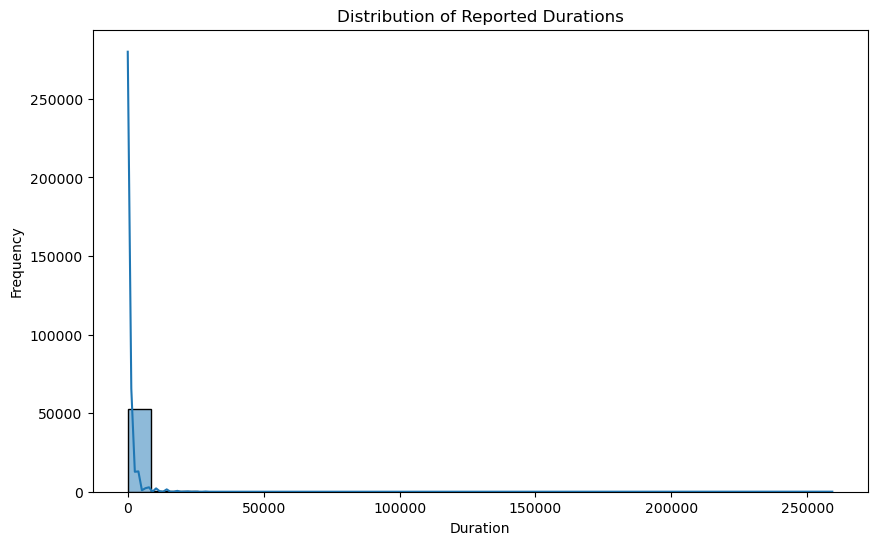

skewness 36.372366804367196


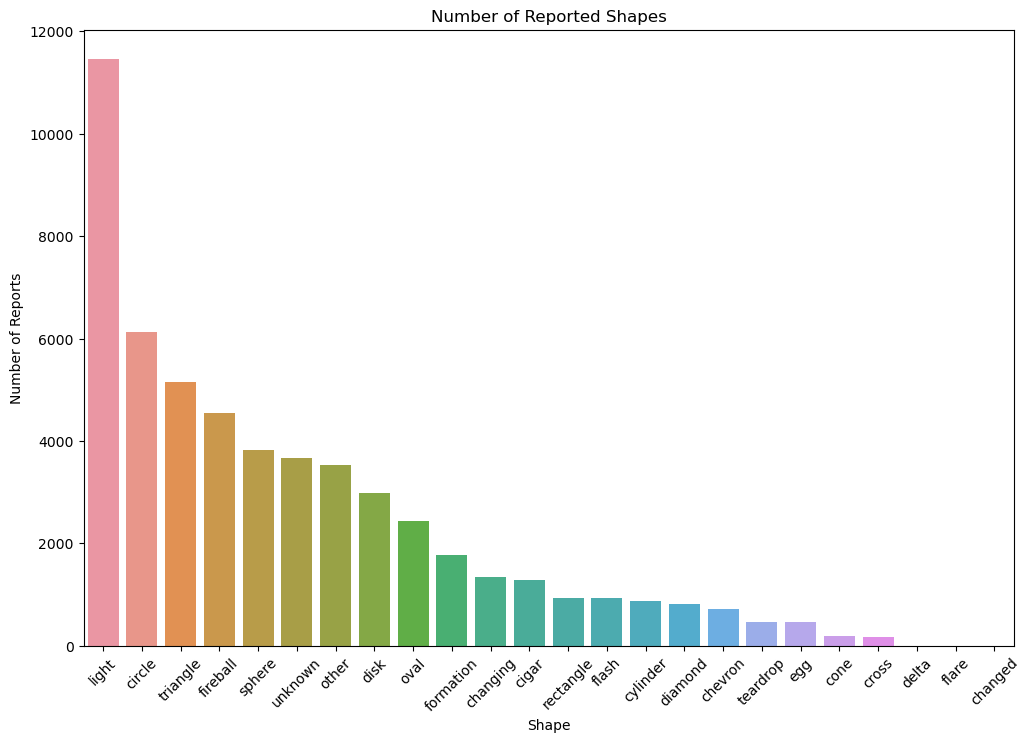

In [9]:
# Histogram of reported duration
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=30, kde=True)
plt.title('Distribution of Reported Durations')
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.savefig('plots/durationHistogram.png')
plt.show()

# Histogram is very skewed, but how much exactly?
skewness = df['duration'].skew()
print("skewness", skewness)
# 36. HIGHLY skewed duration data!!!!

# TODO:
# Figure out how to work with highly skewed data....

# Bar plot of reported shapes
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='shape', order=df['shape'].value_counts().index)
plt.title("Number of Reported Shapes")
plt.xlabel('Shape')
plt.ylabel('Number of Reports')
plt.xticks(rotation=45)
plt.savefig('plots/shapeBarPlot.png')
plt.show()

### Visualize Sightings on a Map

In [ ]:
# TODO

### Thematic Analysis of Sighting Descriptions

In [ ]:
# TODO